In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

KEEP_STEREO = False
DESCRIPTORS = [
    'MolLogP', 'MolMR', 'BalabanJ', 'NumHAcceptors',
    'NumHDonors', 'NumValenceElectrons', 'TPSA'
]

In [88]:
from sklearn.preprocessing import StandardScaler
from preprocess import preprocess_smiles_inplace, add_descriptors_parallel, chunked_ser
from preprocess import randomize_smiles
from preprocess import mem


# df = pd.read_csv('data/250k_rndm_zinc_drugs_clean_3.csv')[['smiles']]
df = pd.read_csv('data/700k_all_chembl.smi.zst', header=None, names=['smiles'])

preprocess_smiles_inplace(df, smiles_col='smiles', keep_stereo=KEEP_STEREO)
df = add_descriptors_parallel(df, DESCRIPTORS)

scaler = StandardScaler()
df.loc[:, DESCRIPTORS] = scaler.fit_transform(df[DESCRIPTORS].values)

df['random_smiles'] = mem.cache(randomize_smiles)(df.smiles)
df.rename(columns={'smiles': 'canonical_smiles'}, inplace=True)

In [89]:
from tokens import extract_tokens_from_smiles
from tqdm import tqdm

all_tokens = set()
for smi in tqdm(df.canonical_smiles):
    all_tokens |= set(extract_tokens_from_smiles(smi))

lookup_table = {token: idx for idx, token in enumerate(sorted(all_tokens))}
lookup_table['<UNK>'] = len(all_tokens)

lookup_table

100%|██████████| 698595/698595 [00:06<00:00, 112164.95it/s]


{'#': 0,
 '%10': 1,
 '%11': 2,
 '%12': 3,
 '%13': 4,
 '%14': 5,
 '%15': 6,
 '%16': 7,
 '%17': 8,
 '%18': 9,
 '%19': 10,
 '%20': 11,
 '%21': 12,
 '%22': 13,
 '(': 14,
 ')': 15,
 '-': 16,
 '1': 17,
 '2': 18,
 '3': 19,
 '4': 20,
 '5': 21,
 '6': 22,
 '7': 23,
 '8': 24,
 '9': 25,
 '=': 26,
 'B': 27,
 'Br': 28,
 'C': 29,
 'Cl': 30,
 'F': 31,
 'I': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'S': 36,
 '[As+]': 37,
 '[As]': 38,
 '[B-]': 39,
 '[BH-]': 40,
 '[BH2-]': 41,
 '[C+]': 42,
 '[C-]': 43,
 '[C]': 44,
 '[I+]': 45,
 '[N+]': 46,
 '[N-]': 47,
 '[NH+]': 48,
 '[NH-]': 49,
 '[NH2+]': 50,
 '[Na]': 51,
 '[O+]': 52,
 '[O-]': 53,
 '[OH+]': 54,
 '[O]': 55,
 '[P+]': 56,
 '[PH]': 57,
 '[S+]': 58,
 '[S-]': 59,
 '[SH+]': 60,
 '[SH]': 61,
 '[Se+]': 62,
 '[SeH]': 63,
 '[Se]': 64,
 '[SiH]': 65,
 '[Si]': 66,
 '[Te]': 67,
 '[Zn-2]': 68,
 '[Zn]': 69,
 '[cH-]': 70,
 '[n+]': 71,
 '[n-]': 72,
 '[nH]': 73,
 '[o+]': 74,
 '[s+]': 75,
 '[se]': 76,
 '[te]': 77,
 'c': 78,
 'n': 79,
 'o': 80,
 's': 81,
 '<UNK>': 82}

In [90]:
def encode_to_tokens(smi):
    return [lookup_table.get(token, '<UNK>') for token in extract_tokens_from_smiles(smi)]

df['input_tokens'] = df['random_smiles'].apply(encode_to_tokens)
df['output_tokens'] = df['canonical_smiles'].apply(encode_to_tokens)

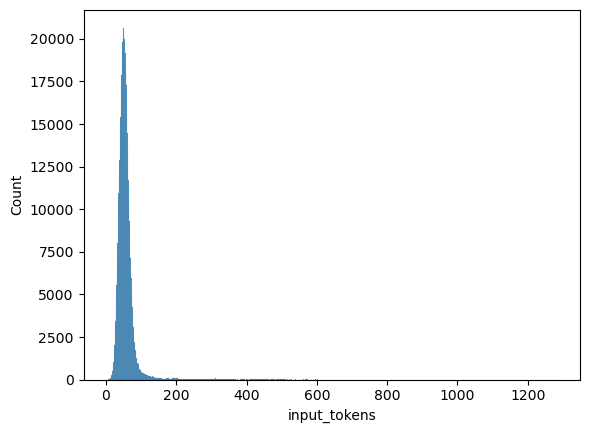

In [91]:
import seaborn as sns

sns.histplot(df['input_tokens'].apply(len), discrete=True);

In [86]:
threshold = df['input_tokens'].apply(len).quantile(0.95)
threshold

90.0

In [81]:
mask = df['input_tokens'].apply(len) < threshold
df = df[mask].copy()

In [82]:
from tokens import pad_tokens_to_max_length_with_lookup

df_padded, updated_lookup_table, max_length = pad_tokens_to_max_length_with_lookup(df, lookup_table)

In [83]:
df_padded

,canonical_smiles,MolLogP,MolMR,BalabanJ,NumHAcceptors,NumHDonors,NumValenceElectrons,TPSA,random_smiles,input_tokens,output_tokens
0,CC1(C)CCC(C)(C)c2cc(-c3cccc(-c4ccc(C(=O)O)cc4)n3)ccc21,1.278502,-0.075610,0.114690,-0.927865,-0.291058,-0.196142,-0.424712,c1c(C(O)=O)ccc(-c2cccc(n2)-c2cc3C(CCC(C)(c3cc2)C)(C)C)c1,"[87, 78, 17, 78, 14, 29, 14, 34, 15, 26, 34, 15, 78, 78, 78, 14, 16, 78, 18, 78, 78, 78, 78, 14, 79, 18, 15, 16, 78, 18, 78, 78, 19, 29, 14, 29, 29, 29, 14, 29, 15, 14, 78, 19, 78, 78, 18, 15, 29, 15, 14, 29, 15, 29, 15, 78, 17, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]","[87, 29, 29, 17, 14, 29, 15, 29, 29, 29, 14, 29, 15, 14, 29, 15, 78, 18, 78, 78, 14, 16, 78, 19, 78, 78, 78, 78, 14, 16, 78, 20, 78, 78, 78, 14, 29, 14, 26, 34, 15, 34, 15, 78, 78, 20, 15, 79, 19, 15, 78, 78, 78, 18, 17, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]"
1,Cc1cc2c(cc1C1=NOC(c3ccc(C(=O)O)cc3)C1)C(C)(C)CCC2(C)C,1.028671,-0.111911,-0.147369,-0.687002,-0.291058,-0.158071,-0.348422,c12cc(c(C3=NOC(c4ccc(cc4)C(=O)O)C3)cc1C(C)(CCC2(C)C)C)C,"[87, 78, 17, 18, 78, 78, 14, 78, 14, 29, 19, 26, 33, 34, 29, 14, 78, 20, 78, 78, 78, 14, 78, 78, 20, 15, 29, 14, 26, 34, 15, 34, 15, 29, 19, 15, 78, 78, 17, 29, 14, 29, 15, 14, 29, 29, 29, 18, 14, 29, 15, 29, 15, 29, 15, 29, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]","[87, 29, 78, 17, 78, 78, 18, 78, 14, 78, 78, 17, 29, 17, 26, 33, 34, 29, 14, 78, 19, 78, 78, 78, 14, 29, 14, 26, 34, 15, 34, 15, 78, 78, 19, 15, 29, 17, 15, 29, 14, 29, 15, 14, 29, 15, 29, 29, 29, 18, 14, 29, 15, 29, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]"
2,Cc1ccc(-c2ccc(C(=O)O)cc2)cc1-c1ccc2c(c1)C(C)(C)CCC2(C)C,1.689765,0.024871,0.231090,-1.168729,-0.291058,-0.139036,-0.537745,c1c(ccc(c1-c1ccc2C(CCC(C)(c2c1)C)(C)C)C)-c1ccc(C(=O)O)cc1,"[87, 78, 17, 78, 14, 78, 78, 78, 14, 78, 17, 16, 78, 17, 78, 78, 78, 18, 29, 14, 29, 29, 29, 14, 29, 15, 14, 78, 18, 78, 17, 15, 29, 15, 14, 29, 15, 29, 15, 29, 15, 16, 78, 17, 78, 78, 78, 14, 29, 14, 26, 34, 15, 34, 15, 78, 78, 17, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]","[87, 29, 78, 17, 78, 78, 78, 14, 16, 78, 18, 78, 78, 78, 14, 29, 14, 26, 34, 15, 34, 15, 78, 78, 18, 15, 78, 78, 17, 16, 78, 17, 78, 78, 78, 18, 78, 14, 78, 17, 15, 29, 14, 29, 15, 14, 29, 15, 29, 29, 29, 18, 14, 29, 15, 29, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]"
3,Cc1cc2c(cc1-c1ncc(-c3ccc(C(=O)O)cc3)s1)C(C)(C)CCC2(C)C,1.445057,-0.037774,0.137799,-0.687002,-0.291058,-0.177107,-0.424712,OC(c1ccc(-c2cnc(s2)-c2cc3c(C(CCC3(C)C)(C)C)cc2C)cc1)=O,"[87, 34, 29, 14, 78, 17, 78, 78, 78, 14, 16, 78, 18, 78, 79, 78, 14, 81, 18, 15, 16, 78, 18, 78, 78, 19, 78, 14, 29, 14, 29, 29, 29, 19, 14, 29, 15, 29, 15, 14, 29, 15, 29, 15, 78, 78, 18, 29, 15, 78, 78, 17, 15, 26, 34, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]","[87, 29, 78, 17, 78, 78, 18, 78, 14, 78, 78, 17, 16, 78, 17, 79, 78, 78, 14, 16, 78, 19, 78, 78, 78, 14, 29, 14, 26, 34, 15, 34, 15, 78, 78, 19, 15, 81, 17, 15, 29, 14, 29, 15, 14, 29, 15, 29, 29, 29, 18, 14, 29, 15, 29, 88, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]"
4,Cc1ccc(-c2ccc(C(=O)O)cc2)cc1-c1cc2c(cc1C)C(C)(C)CCC2(C)C,1.828629,0.093436,0.356567,-1.168729,-0.291058,-0.081930,-0.537745,OC(=O)c1ccc(cc1)-c1cc(-c2cc3C(C)(CCC(c3cc2C)(C)C)C)c(cc1)C,"[87, 34, 29, 14, 26, 34, 15, 78, 17, 78, 78, 78, 14,

In [92]:
from tqdm import tqdm
if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

In [4]:
from main import prepare_dataset

df, scaler, lookup_table, max_length = prepare_dataset('data/250k_rndm_zinc_drugs_clean_3.csv', smiles_col='smiles', len_quantile=0.99)
max_length

[05:18:42] Initializing Normalizer
Building token set: 100%|██████████| 249455/249455 [00:01<00:00, 211915.05it/s]


Tokenizing SMILES strings...
Filtering tokens by sequence length...
Padding token sequences...


65

In [4]:
df, scaler, lookup_table, max_length = prepare_dataset('data/700k_all_chembl.smi.zst')

max_length

Building token set: 100%|██████████| 698595/698595 [00:04<00:00, 161622.54it/s]


Encoding SMILES strings...
Filtering tokens by sequence length...
Padding token sequences...


90

In [23]:
df, scaler, lookup_table, max_length = prepare_dataset('data/600k_chembl_filtered.smi.zst', len_quantile=0.95)
max_length

Building token set: 100%|██████████| 636218/636218 [00:04<00:00, 147694.71it/s]


Tokenizing SMILES strings...
Filtering tokens by sequence length...
Padding token sequences...


77

In [24]:
df, scaler, lookup_table, max_length = prepare_dataset('data/600k_chembl_filtered.smi.zst', len_quantile=0.99)
max_length

Building token set: 100%|██████████| 636218/636218 [00:03<00:00, 171834.39it/s]


Tokenizing SMILES strings...
Filtering tokens by sequence length...
Padding token sequences...


81

In [9]:
import torch
from models import Encoder
from utils import load_lookup_table

lookup_table = load_lookup_table('250k_zinc_output/lookup_table.json')
encoder = Encoder(vocab_size=len(lookup_table))
encoder.load_state_dict(torch.load('250k_zinc_output/models/encoder_model.pt'))
encoder

/tmp/ipykernel_11276/3006119689.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('250k_zinc_output/models/encoder_model.pt'))


Encoder(
  (gru1): GRU(46, 512, batch_first=True)
  (gru2): GRU(512, 1024, batch_first=True)
  (gru3): GRU(1024, 2048, batch_first=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (latent_projection): Linear(in_features=3584, out_features=512, bias=True)
  (gaussian_noise): GaussianNoise()
)

In [10]:
from tokens import SmilesTokenizer
tokenizer = SmilesTokenizer(lookup_table=lookup_table, max_length=60)
tokenizer.tokenize('CO')

array([44, 14, 19, 45, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43])

In [11]:
vec = encoder(torch.tensor(tokenizer.batch_tokenize(['CO', 'CN']))).detach().numpy()

print(vec)

[[-0.5967816   0.1704576  -0.14761288 ...  0.00169486  0.5972924
   0.62065905]
 [-0.5854546  -0.00093883  0.04204349 ...  0.09034973  0.40804797
   0.49407646]]


In [12]:
import pandas as pd
df = pd.read_csv('data/600k_chembl_filtered.smi.zst', header=None, names=['smiles'])

In [13]:
tokenizer.batch_tokenize(['CO', 'CN'])

array([[44, 14, 19, 45, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43],
       [44, 14, 18, 45, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]])

In [14]:
import numpy as np
from tqdm import tqdm

token_ids = []

for smi in tqdm(df.smiles[:1000]):
    ids = tokenizer.tokenize(smi)
    token_ids.append(ids)
    if len(ids) != 60:
        print(smi)

100%|██████████| 1000/1000 [00:00<00:00, 45564.51it/s]


In [15]:
tokenizer.tokenize('CC1=NN(c2ccccc2)C(=O)C1C=C1C(=O)NC(=O)N(c2cc(C)cc(C)c2)C1=O')

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [16]:
token_arr = tokenizer.batch_tokenize(df.smiles.tolist())
token_arr.shape

(636218, 60)

In [17]:
mask = ~np.isnan(token_arr).any(axis=1)

In [18]:
token_arr[mask].shape

(510200, 60)

In [19]:
token_arr[mask].astype(np.int32)

array([[44, 14, 14, ..., 43, 43, 43],
       [44, 14, 38, ..., 43, 43, 43],
       [44, 14, 38, ..., 43, 43, 43],
       ...,
       [44, 14, 14, ...,  4, 45, 43],
       [44, 14, 14, ..., 43, 43, 43],
       [44, 14, 14, ..., 38,  4, 45]], dtype=int32)

In [21]:
import torch
import numpy as np

# Assuming token_arr[mask] is already defined
token_tensor = torch.tensor(token_arr[mask], dtype=torch.int64)

# Move token tensor to CUDA
token_tensor = token_tensor.to('cuda:0')
encoder = encoder.to('cuda:0')

# Define batch size
batch_size = 128  # Adjust based on available GPU memory
batches = torch.split(token_tensor, batch_size)

# List to store output vectors
cddd_vec_list = []

# Iterate over batches
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in tqdm(batches):
        batch_vec = encoder(batch).detach().cpu().numpy().astype(np.float32)  # Convert to float32
        cddd_vec_list.append(batch_vec)

# Concatenate results
cddd_vec = np.concatenate(cddd_vec_list, axis=0)  # Assuming output is 2D (N, D)

print(f"Final shape: {cddd_vec.shape}, dtype: {cddd_vec.dtype}")


100%|██████████| 3986/3986 [00:10<00:00, 389.69it/s]


Final shape: (510200, 512), dtype: float32


In [1]:
%load_ext autoreload
%autoreload 2

from inference import SMILESEncoder

encoder = SMILESEncoder('250k_zinc_output')

In [2]:
encoder(['CO', 'CN'])

Encoding SMILES: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


array([[-0.6304246 ,  0.23668163, -0.00931907, ...,  0.07803214,
         0.50458324,  0.6139616 ],
       [-0.54407984,  0.03470555,  0.01278339, ...,  0.01867415,
         0.50783044,  0.53454304]], dtype=float32)

In [3]:
smi = 'CCOc1ccc(OCC)c([C@H]2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C(=O)CCC3)c1'
encoder(smi)

Encoding SMILES: 100%|██████████| 1/1 [00:00<00:00, 51.89it/s]


array([-2.33346045e-01,  2.11809397e-01,  4.50099260e-01, -7.23448694e-01,
        1.80236727e-01,  1.35352593e-02,  4.74113375e-01,  3.51042718e-01,
       -4.86536413e-01, -3.16497356e-01, -6.60222471e-01,  3.79078835e-01,
       -2.27939427e-01, -1.91705544e-02, -6.02066278e-01, -2.76844561e-01,
       -4.36519206e-01,  4.66927290e-01,  2.91375309e-01, -6.92498326e-01,
       -4.78886276e-01, -3.46891791e-01,  1.58121943e-01, -6.30861402e-01,
       -1.69504151e-01,  3.49664867e-01,  2.80315787e-01, -4.18642730e-01,
        1.56774402e-01,  5.10418355e-01, -1.76414400e-02, -2.30628289e-02,
        2.22075954e-01,  3.36660981e-01,  8.68375376e-02, -8.55920315e-02,
       -5.31400859e-01,  4.54104990e-01,  1.81561798e-01,  2.39016756e-01,
        6.30357742e-01, -2.71569435e-02, -3.37951332e-02,  3.20367396e-01,
        3.59472275e-01,  2.44849622e-01,  1.89236030e-01, -1.87072575e-01,
       -4.48063314e-01,  1.15371309e-01, -5.85734725e-01, -8.03245138e-03,
        7.35326648e-01,  

In [4]:
encoder.tokenizer.tokenize(smi)

array([44, 14, 14, 19, 38,  4, 38, 38, 38,  1, 19, 14, 14,  2, 38,  1, 42,
        5, 14,  1, 14,  0, 18,  2, 12, 14,  1, 18,  2, 18,  1, 38,  6, 38,
       38, 38, 38, 38,  6, 14,  1, 16,  2,  1, 16,  2, 16,  2, 14,  6, 12,
       14,  5, 14,  1, 12, 19,  2, 14, 45])

In [6]:
import pandas as pd
df = pd.read_csv('data/250k_rndm_zinc_drugs_clean_3.csv')[['smiles']]

In [7]:
encoder(df.smiles)

Encoding SMILES: 100%|██████████| 3898/3898 [00:06<00:00, 571.06it/s]


array([[-0.28182882, -0.13454095, -0.11872078, ..., -0.282257  ,
        -0.16449887,  0.44023547],
       [-0.29591104, -0.2470757 , -0.231886  , ...,  0.1065323 ,
         0.128735  , -0.59969556],
       [-0.02900665, -0.30289793, -0.10597746, ..., -0.05631225,
         0.2070439 ,  0.44529995],
       ...,
       [-0.27128732, -0.2090925 ,  0.17025048, ..., -0.05494078,
         0.00831078,  0.32568377],
       [-0.19690284,  0.01924747, -0.07598521, ..., -0.1908015 ,
        -0.05643069,  0.0929241 ],
       [ 0.66773605, -0.14579004,  0.6943203 , ..., -0.11735951,
         0.6665484 ,  0.851227  ]], dtype=float32)